# Network Optimization
    Optimizing a network's virtual backbone using Graph Theory

## Import Tools

### Import Graph Tool Modules
    Specifically graph_tool main, draw and collection modules

In [6]:
import graph_tool.all
import graph_tool as gt
import graph_tool.draw
import graph_tool.collection

### Import Other Required Modules
    These Modules include Matplotlib

In [7]:
import matplotlib as mpl

In [8]:
%matplotlib inline

In [9]:
import _pickle as pickle

In [10]:
from tqdm import tqdm_notebook as tqdm

In [11]:
from enum import Enum

## Algorithms

### Exact Exponential Algorithms

#### Minimum Dominating Set
    A bitmask approach to compute the minimum dominating set of a graph

In [12]:
def min_dominating_set_e1(graph):
    vertices = list(graph.vertices())
    vertex_neighbours_dict = {}

    for vertex in graph.vertices():
        vertex_neighbours = set(vertex.out_neighbors())
        vertex_neighbours.add(vertex)
        vertex_neighbours_dict[vertex] = vertex_neighbours

    min_dominating_set = set(vertices)

    for i in tqdm(range(2**(len(vertices)))):
        dominated = set()
        dominating = set()
        for j in range(len(vertices)):
            if not i&(1<<j):
                continue
            dominating.add(vertices[j])
            if len(dominating) >= len(min_dominating_set):
                break
            dominated = dominated.union(vertex_neighbours_dict[vertices[j]])
            if len(dominated) == len(vertices):
                min_dominating_set = dominating
                break
    
    dominated_property_map = graph.new_vertex_property("bool")
    dominated_property_map.set_value(0)
    for vertex in min_dominating_set:
        dominated_property_map[vertex] = 1
    
    return dominated_property_map

In [13]:
def min_dominating_set_e2(graph):
#https://ac.els-cdn.com/S0166218X11002393/1-s2.0-S0166218X11002393-main.pdf?_tid=2f975e0a-6fcd-4926-a7ac-f93b6265cf0a&acdnat=1534822962_d706d676ada4b2561924be5cb7565e4a

   

    vertices = graph.vertices()

    dominated_set = set()

    dominating_set = set()

    vertex_neighbours_dict = {}

    frequency_dict = {}

    # the set of vertices that dont need to be checked for dominater
    ignore_vertices = set()

    # the set of vertices that dont need to be checked 
    invisible_vertices = set()

    for vertex in graph.vertices():
        vertex_neighbours = set(vertex.out_neighbors())
        vertex_neighbours.add(vertex)
        vertex_neighbours_dict[vertex] = vertex_neighbours

    for vertex in graph.vertices():
        vertex_neighbours = set(vertex.out_neighbors())
        frequency_dict[vertex] = vertex_neighbours

    for vertex in vertex_neighbours_dict.keys():
        if len(set(vertex.out_neighbours())) == 1:
            dominated_set.add(vertex)
            dominating_set = dominating_set.union(set(vertex.out_neighbours()))

    for v,n in vertex_neighbours_dict.items():
        if v in ignore_vertices:
            continue
        for vertex, neighbours in vertex_neighbours_dict.items():
            if vertex == v:
                continue
            if neighbours.issubset(n):
                ignore_vertices.add(vertex)



    for vertex, neighbours in vertex_neighbours_dict.items():
        if vertex in invisible_vertices:
            continue
        neighbour_intersection = set()
        neighbour_intersection = neighbour_intersection.union(neighbours)
        for neighbour in neighbours:
            neighbour_intersection = neighbour_intersection.intersection(neighbour.out_neighbours())
        invisible_vertices = invisible_vertices.union(neighbour_intersection)

    frequency_2_vertices = set()

    for vertex, neighbours in frequency_dict.items():
        if len(neighbours) == 2:
            frequency_2_vertices.add(vertex)

    must_take_dominaters = set()
    pre_dominated = set()

    for vertex, neighbours in vertex_neighbours_dict.items():
        if vertex in pre_dominated:
            continue
        frequency_2_neighbours = neighbours.intersection(frequency_2_vertices)
        q = 0
        for v, n in vertex_neighbours_dict.items():
            if v == vertex:
                continue
            common_2_frequency = frequency_2_neighbours.intersection(n)
            if common_2_frequency:
                q += len(n) - len(common_2_frequency)
        if q < len(neighbours):
            must_take_dominaters.add(vertex)
            pre_dominated = pre_dominated.union(vertex_neighbours_dict[vertex])

    return ignore_vertices, invisible_vertices, must_take_dominaters, pre_dominated

#### Minimum Connected Dominating Set
    A bitmask approach to compute the minimum connected dominating set of a graph

In [14]:
def min_connected_dominating_set_e1(graph):
    vertices = list(graph.vertices())
    vertex_neighbours_dict = {}

    for vertex in graph.vertices():
        vertex_neighbours = set(vertex.out_neighbors())
        vertex_neighbours.add(vertex)
        vertex_neighbours_dict[vertex] = vertex_neighbours

    min_dominating_set = set(vertices)

    for i in tqdm(range(2**(len(vertices)))):
        dominated = set()
        dominating = set()
        for j in range(len(vertices)):
            if not i&(1<<j):
                continue
            if j>0 and not vertices[j] in dominated:
                continue
                
            dominating.add(vertices[j])
            
            if len(dominating) >= len(min_dominating_set):
                break
            dominated = dominated.union(vertex_neighbours_dict[vertices[j]])
            if len(dominated) == len(vertices):
                min_dominating_set = dominating
                break
    
    dominated_property_map = graph.new_vertex_property("bool")
    dominated_property_map.set_value(0)
    for vertex in min_dominating_set:
        dominated_property_map[vertex] = 1
    
    return dominated_property_map

### Heuristic Approximate Algorithms

#### Minimum Dominating Set
    A Greedy approach for computing the minimum dominating set of an undirected graph

In [15]:
def helper_min_dominating_set_h1(graph):
#     import pdb; pdb.set_trace()
    dominated_set = set()
    dominating_set = set()
    vertex_neighbours_dict = {}
#     total_vertices = len(graph.vertices())
    
    for vertex in graph.vertices():
        vertex_neighbours = set(vertex.out_neighbors())
        vertex_neighbours.add(vertex)
        vertex_neighbours_dict[vertex] = vertex_neighbours
    
#     print(vertex_neighbours_dict)
    
    def get_max_potential_vertex():
        max_potential = 0
        max_p_vertex = None
        for vertex, neighbours in vertex_neighbours_dict.items():
            if len(neighbours) > max_potential:
                max_potential = len(neighbours)
                max_p_vertex = vertex
        return max_p_vertex
    
    while vertex_neighbours_dict:
        current_vertex = get_max_potential_vertex()
#         print("The current vertex is", current_vertex)
#         print("The current dominated set is", dominated_set)
#         print("The neighbours not dominated yet for the current vertex is", vertex_neighbours_dict[current_vertex])
        current_vertex_neighbours = vertex_neighbours_dict.pop(current_vertex, None)
#         print("Recheck", current_vertex_neighbours)
        dominated_set = dominated_set.union(current_vertex_neighbours)
        dominating_set.add(current_vertex)
        to_delete = set()
        for vertex, neighbours in vertex_neighbours_dict.items():
            neighbours = neighbours.difference(current_vertex_neighbours)
            vertex_neighbours_dict[vertex] = neighbours
            if not neighbours:
                to_delete.add(vertex)
        for vertex in to_delete:
            vertex_neighbours_dict.pop(vertex)
        
    return dominating_set    

In [16]:
def min_dominating_set_h1(graph):
    dominating_set = helper_min_dominating_set_h1(graph)
    dominated_property_map = graph.new_vertex_property("bool")
    dominated_property_map.set_value(0)
    for vertex in dominating_set:
        dominated_property_map[vertex] = 1
    
    return dominated_property_map
        

#### Minimum Connected Dominating Set
    A Greedy approach to compute the minimum connected dominating set of a graph

In [17]:
def helper_min_connected_dominating_set_h1(graph):
    dominated_set = set()
    dominating_set = set()
    vertex_neighbours_dict = {}
    possible_vertex_options = set()
    
    for vertex in graph.vertices():
        vertex_neighbours = set(vertex.out_neighbors())
        vertex_neighbours.add(vertex)
        vertex_neighbours_dict[vertex] = vertex_neighbours
    
    
    def get_max_potential_vertex(iterable):
        max_potential = 0
        max_p_vertex = None
        for vertex in iterable:
            neighbours = vertex_neighbours_dict.get(vertex, [])
            if len(neighbours) > max_potential:
                max_potential = len(neighbours)
                max_p_vertex = vertex
        return max_p_vertex
    
    first_vertex = get_max_potential_vertex(vertex_neighbours_dict.keys())
    possible_vertex_options.add(first_vertex)
    
    
    
    while possible_vertex_options:
        current_vertex = get_max_potential_vertex(possible_vertex_options)
        if not current_vertex:
            break
        possible_vertex_options.remove(current_vertex)
        to_delete = set()
        current_vertex_neighbours = vertex_neighbours_dict.pop(current_vertex, set())
        possible_vertex_options = possible_vertex_options.union(current_vertex_neighbours)
        dominated_set = dominated_set.union(current_vertex_neighbours)
        dominating_set.add(current_vertex)
        for vertex, neighbours in vertex_neighbours_dict.items():
            neighbours = neighbours.difference(current_vertex_neighbours)
            vertex_neighbours_dict[vertex] = neighbours
            if not neighbours:
                to_delete.add(vertex)
        for vertex in to_delete:
            vertex_neighbours_dict.pop(vertex)
        

    return dominating_set
    

In [18]:
def min_connected_dominating_set_h1(graph):
    dominating_set = helper_min_connected_dominating_set_h1(graph)
    dominated_property_map = graph.new_vertex_property("bool")
    dominated_property_map.set_value(0)
    for vertex in dominating_set:
        dominated_property_map[vertex] = 1
    
    return dominated_property_map


### Miscellaneous Algorithms

In [19]:
#### Convert set to property map

In [20]:
def get_map(graph, function):
    dominating_set = function(graph)
    dominated_property_map = graph.new_vertex_property("bool")
    dominated_property_map.set_value(0)
    for vertex in dominating_set:
        dominated_property_map[vertex] = 1
    
    return dominated_property_map

#### Algorithm to check for Unique Dominating Set

In [21]:
# inputs: graph, dominating set
# for each vertex in the graph, find its neighbours in the dominating set
# for vertices (not belonging to the dominating set) with a single neighbour in the Dominating Set, update the corresponding neighbour
# check whether all vertices of the dominating set have atleast 2 updates
# return condition

In [22]:
def check_unique_dominating_set(graph, dominating_set):
    
    vertices = set(graph.vertices())
    dominated_vertices = vertices.difference(set(dominating_set))
    count = {}
    for v in dominating_set:
        count[v] = 0
    for v in dominated_vertices:
        neighbours = set(v.out_neighbours())
        dominators = list(neighbours.intersection(dominating_set))
        if len(dominators) == 1:
            count[dominators[0]] += 1
    
    for k,v in count.items():
        if v<2:
            return False
    
    return True

### Helper Tool

In [23]:
class Algorithms(Enum):
    MIN_DOMINATING_SET =1
    MIN_CONNECTED_DOMINATING_SET =2
    MIN_WEIGHT_DOMINATING_SET =3
    MIN_WEIGHT_CONNECTED_DOMINATING_SET =4

In [24]:
def compute(graph, algorithm, exact=False):
    
    if exact:
        return Exact.compute(graph, algorithm)
    if not exact:
        return Heuristic.compute(graph, algorithm)
    

In [25]:
class Exact:
    
    algorithm_dict = {}
    algorithm_dict[Algorithms.MIN_CONNECTED_DOMINATING_SET] = min_connected_dominating_set_e1
    algorithm_dict[Algorithms.MIN_DOMINATING_SET] = min_dominating_set_e1
    def compute(graph, algorithm):
        return Exact.algorithm_dict[algorithm](graph)

In [26]:
class Heuristic:
    
    algorithm_dict = {}
    algorithm_dict[Algorithms.MIN_CONNECTED_DOMINATING_SET] = min_connected_dominating_set_h1
    algorithm_dict[Algorithms.MIN_DOMINATING_SET] = min_dominating_set_h1
    def compute(graph, algorithm):
        return Heuristic.algorithm_dict[algorithm](graph)

In [27]:
class ConstantFactor:
    pass

In [28]:
class Genetic:
    pass

In [29]:
class ArtificialBeeColony:
    pass

## Sample Graphs

### Library Collections

#### List of available graphs

In [30]:
list(gt.collection.data.keys())

['adjnoun',
 'as-22july06',
 'astro-ph',
 'celegansneural',
 'cond-mat',
 'cond-mat-2003',
 'cond-mat-2005',
 'dolphins',
 'email-Enron',
 'football',
 'hep-th',
 'karate',
 'lesmis',
 'netscience',
 'pgp-strong-2009',
 'polblogs',
 'polbooks',
 'power',
 'serengeti-foodweb']

##### Visualise Graph

In [31]:
# select graph from library collection
graph = gt.collection.data["football"]

In [32]:
# uniform position 
pos = gt.draw.sfdp_layout(graph)

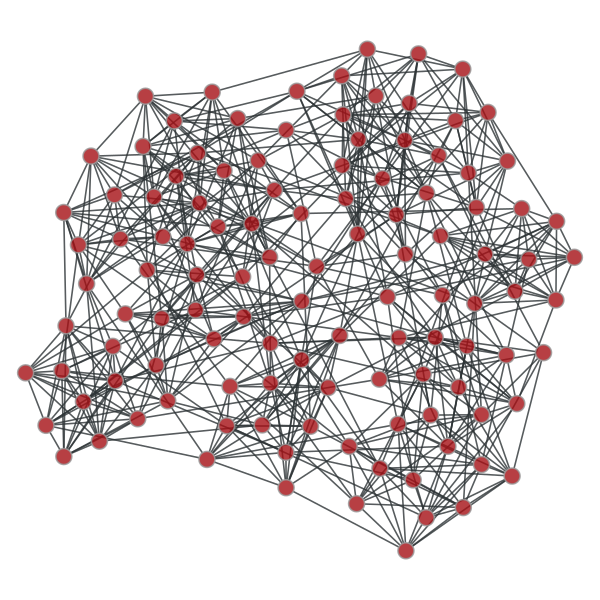

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1253447b8, at 0x125359c50>

In [33]:
gt.draw.graph_draw(graph, pos=pos)

##### Minimum Dominating Set

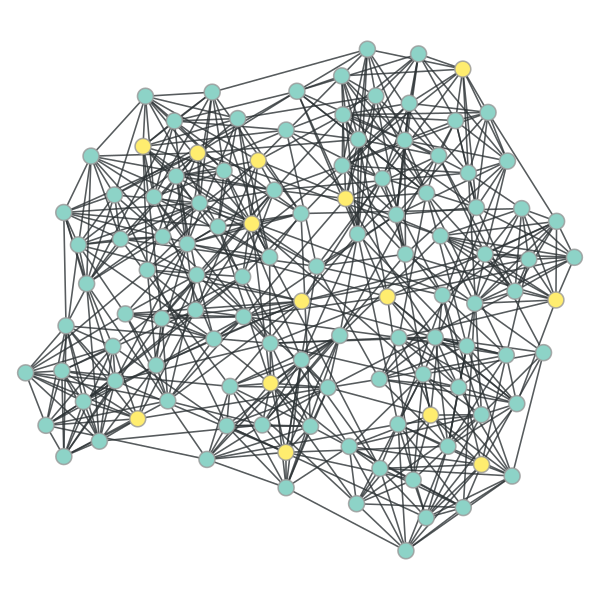

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1253447b8, at 0x125359c50>

In [34]:
gt.draw.graph_draw(graph, vertex_fill_color=compute(graph, Algorithms.MIN_DOMINATING_SET, exact=False ), pos=pos)

##### Minimum Connected Dominating Set

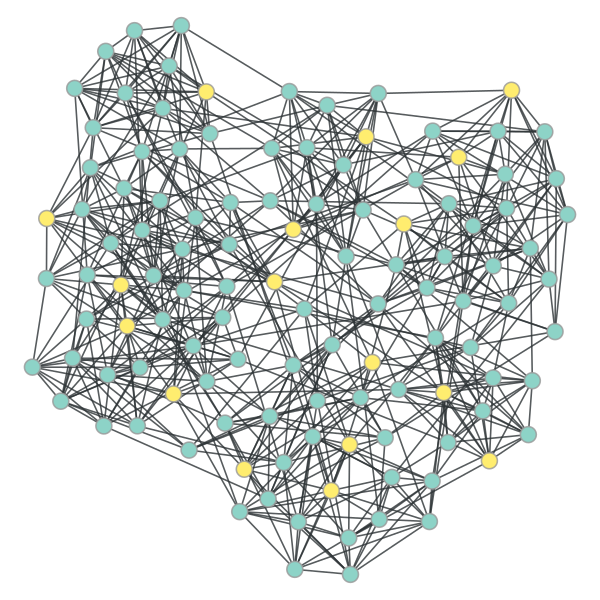

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1253447b8, at 0x12538a630>

In [35]:
gt.draw.graph_draw(graph, vertex_fill_color=compute(graph, Algorithms.MIN_CONNECTED_DOMINATING_SET, exact=False ))

### Custom Graphs

#### Lattice Graph

##### Visualize Graph

In [37]:
graph = gt.generation.lattice([5,5,5], periodic=False)

In [33]:
pos = gt.draw.sfdp_layout(graph)

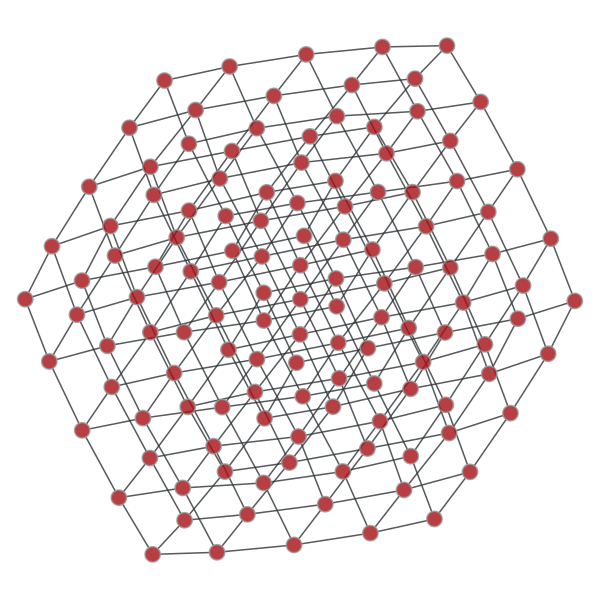

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x12e171c88, at 0x12e171be0>

In [34]:
gt.draw.graph_draw(graph, pos=pos)

##### Minimum Dominating Set

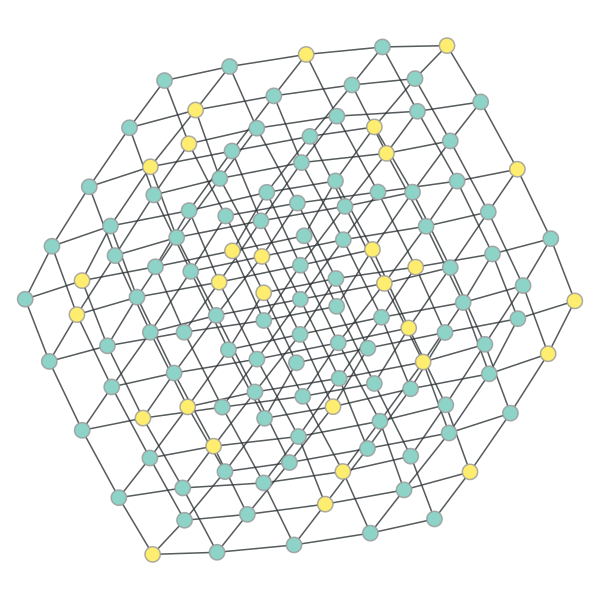

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x12e171c88, at 0x12e171be0>

In [35]:
gt.draw.graph_draw(graph, pos=pos, vertex_fill_color=compute(graph, Algorithms.MIN_DOMINATING_SET, exact=False ) )

##### Minimum Connected Dominating Set

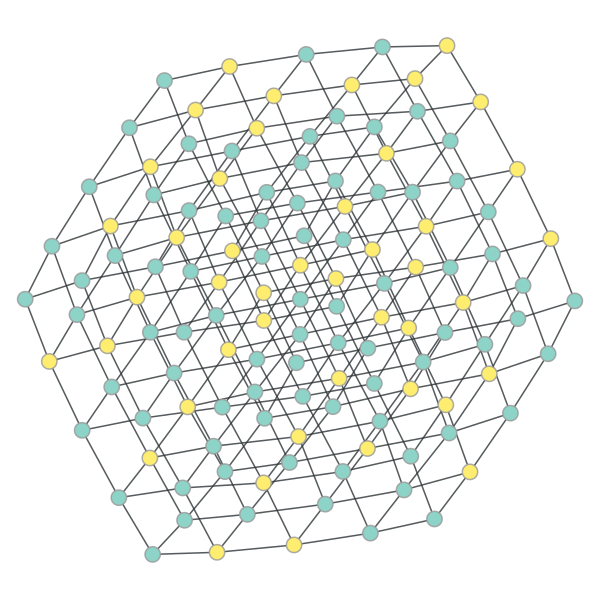

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x12e171c88, at 0x12e171be0>

In [36]:
gt.draw.graph_draw(graph, pos=pos, vertex_fill_color=compute(graph, Algorithms.MIN_CONNECTED_DOMINATING_SET, exact=False ))

#### Random Graph

In [37]:
# limit 10
from random import random as random_number
def random_degree_sampler():
    return int((random_number()*10) +1)

##### Visualize Graph

In [38]:
graph = gt.generation.random_graph(N=200, deg_sampler=random_degree_sampler, directed=False, verbose=True )

In [39]:
pos = gt.draw.sfdp_layout(graph)

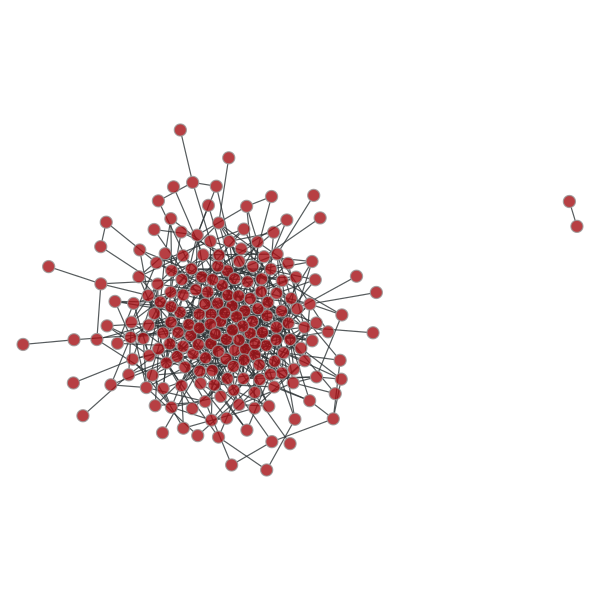

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x12e19a278, at 0x12e19a7f0>

In [40]:
gt.draw.graph_draw(graph, pos=pos)

##### Minimum Dominating Set

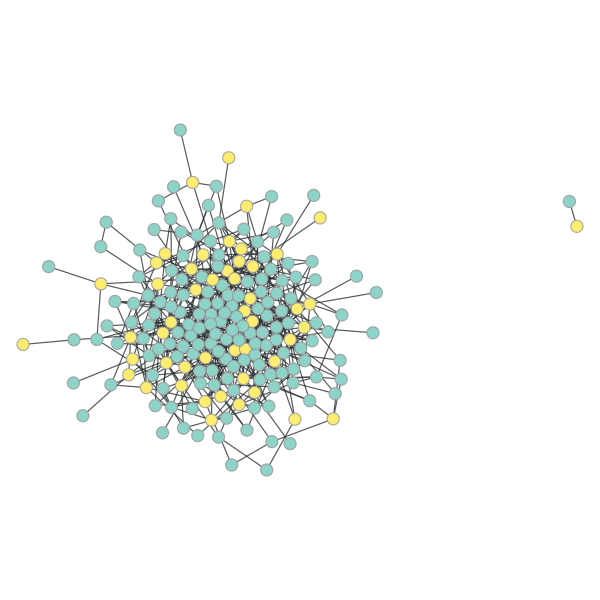

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x12e19a278, at 0x12e19a7f0>

In [41]:
gt.draw.graph_draw(graph, pos=pos, vertex_fill_color=compute(graph, Algorithms.MIN_DOMINATING_SET, exact=False ))

##### Minimum Connected Dominating Set

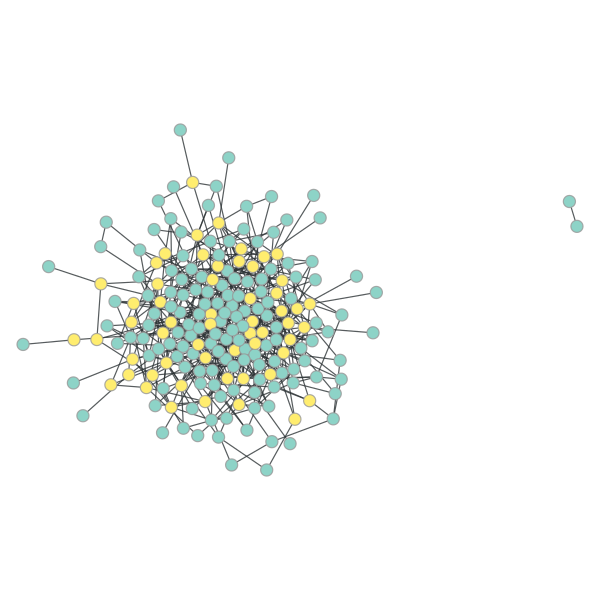

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x12e19a278, at 0x12e19a7f0>

In [42]:
gt.draw.graph_draw(graph, pos=pos, vertex_fill_color=compute(graph, Algorithms.MIN_CONNECTED_DOMINATING_SET, exact=False ))

#### Circular Graph

##### Visualize Graph

In [43]:
graph = gt.generation.circular_graph(N=24, directed=False, k=1)

In [39]:
pos = gt.draw.sfdp_layout(graph)

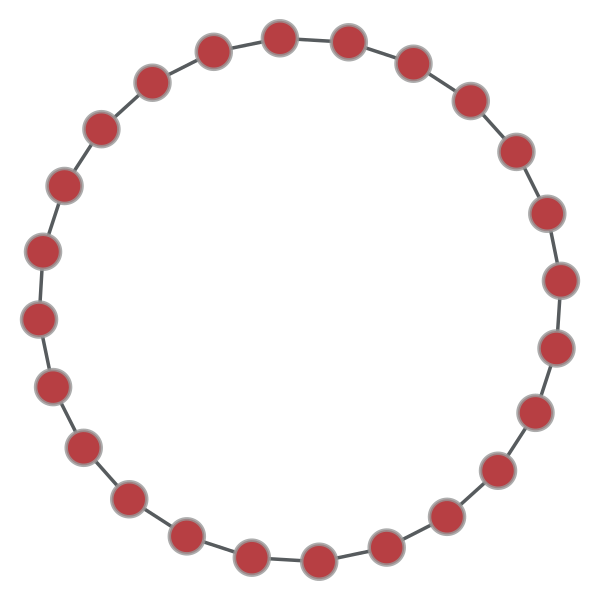

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x12e19ac50, at 0x12e19ae80>

In [45]:
gt.draw.graph_draw(graph, pos=pos)

##### Minimum Dominating Set

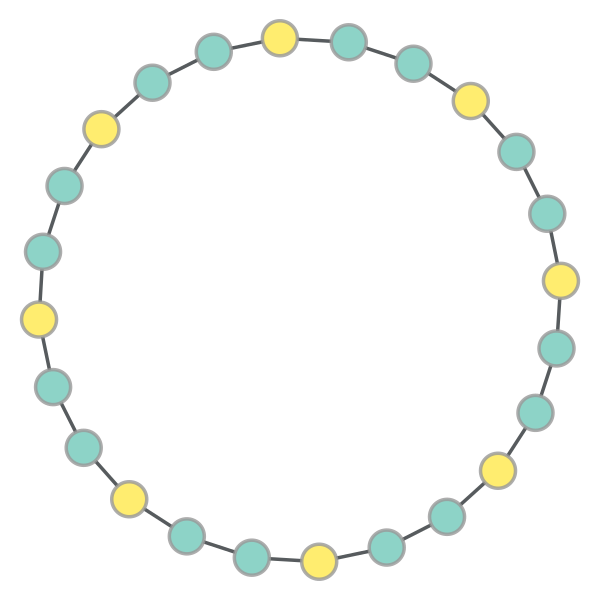

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x12e19ac50, at 0x12e19ae80>

In [46]:
gt.draw.graph_draw(graph, pos=pos, vertex_fill_color=compute(graph, Algorithms.MIN_DOMINATING_SET, exact=False ))

In [47]:
# gt.draw.GraphWidget(graph, pos=pos, vertex_fill_color=min_dominating_set(graph))

##### Minimum Connected Dominating Set

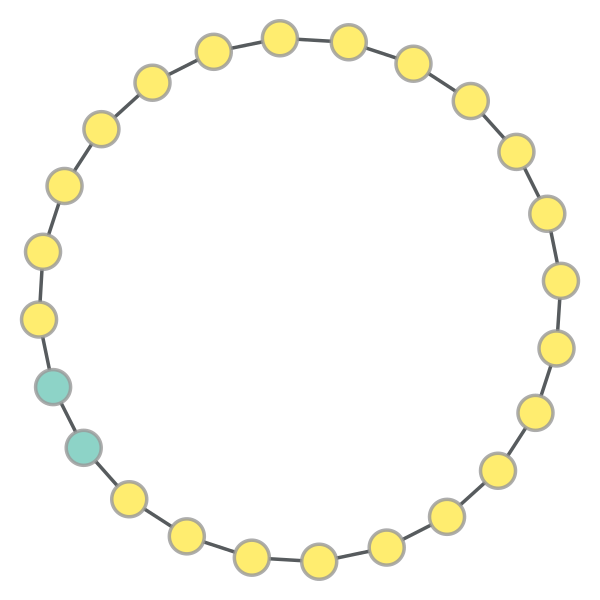

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x12e19ac50, at 0x12e19ae80>

In [48]:
gt.draw.graph_draw(graph, pos=pos, vertex_fill_color=compute(graph, Algorithms.MIN_CONNECTED_DOMINATING_SET, exact=False ))

#### Triangular Graph

In [50]:
# with open('simple_triangular_undirected_graph.pickle', 'wb') as f:
#     pickle.dump(graph, f)

In [51]:
with open('simple_triangular_undirected_graph.pickle', 'rb') as f:
    graph = pickle.load(f)

In [ ]:
gt.draw.graph_draw(graph, vertex_text=graph.vertex_index)

### Counter Example Graphs

#### Greedy Heuristic Algorithms

In [52]:
# with open('counter_example_greedy_heuristic.pickle', 'wb') as f:
#     pickle.dump(save_counter_example_graph_1, f)

In [5]:
with open('counter_example_greedy_heuristic.pickle', 'rb') as f:
    graph = pickle.load(f)

NameError: name 'pickle' is not defined

In [ ]:
pos = gt.draw.sfdp_layout(graph)

In [ ]:
gt.draw.graph_draw(graph,  vertex_text=graph.vertex_index, pos=pos)

##### Approximate Algorithm Results

In [ ]:
gt.draw.graph_draw(graph, vertex_fill_color=compute(graph, Algorithms.MIN_DOMINATING_SET, exact=False ), vertex_text=graph.vertex_index, pos=pos)

In [ ]:
gt.draw.graph_draw(graph,vertex_fill_color=compute(graph, Algorithms.MIN_CONNECTED_DOMINATING_SET, exact=False ), vertex_text=graph.vertex_index, pos=pos)

##### Exact Algorithm Results

In [ ]:
gt.draw.graph_draw(graph, vertex_fill_color=compute(graph, Algorithms.MIN_DOMINATING_SET, exact=True), vertex_text=graph.vertex_index, pos=pos)

In [ ]:
gt.draw.graph_draw(graph, vertex_fill_color=compute(graph, Algorithms.MIN_CONNECTED_DOMINATING_SET, exact=True), vertex_text=graph.vertex_index, pos=pos)

In [3]:
gt.draw.interactive_window(graph, pos=pos,vertex_fill_color=compute(graph, Algorithms.MIN_DOMINATING_SET, exact=True ), vertex_text=graph.vertex_index )

AttributeError: module 'graph_tool.draw' has no attribute 'interactive_window'

In [43]:
gt.draw.cairo_draw??

#### Test Graph

In [54]:
graph = gt.Graph(directed=False)

In [ ]:
pos = gt.draw.planar_layout(graph)

In [ ]:
graph.add_edge_list([(0,1),(1,2),(2,5),(5,7),(7,4),(4,6),(1,4),(1,3),(3,6)])

In [ ]:
gt.draw.interactive_window(graph, pos=pos, vertex_text=graph.vertex_index )

In [64]:
graph.add_edge(3,2)

<Edge object with source '3' and target '2' at 0x10a86a378>

In [63]:
graph.add_vertex()

<Vertex object with index '3' at 0x10a851870>

In [65]:
check_unique_dominating_set(graph, helper_min_dominating_set_h1(graph))

False